# Determining the age of buyers

## Data Description

Used data is [ChaLearn Looking at People](http://chalearnlap.cvc.uab.es/dataset/26/description/)

The APPA-REAL database contains 7,591 images with associated real and apparent age labels. The total number of apparent votes is around 250,000. On average we have around 38 votes per each image and this makes the average apparent age very stable (0.3 standard error of the mean).

The images are split into 4113 train, 1500 valid and 1978 test images, provided in the folders train/, valid/ and test/. For each image X.jpg, we also provide a corresponding X.jpg_face.jpg which contains the cropped & rotated face with a 40% margin obtained from the [Mathias et. al face detector](http://markusmathias.bitbucket.org/2014_eccv_face_detection/) at multiple rotations. Furthermore, an X.jpg.mat file is provided with meta-information about the detected face.

The real age and apparent age ratings are provided in the files gt_train.csv, gt_test.csv and gt_valid.csv, with a separate row for each rating.

Furthermore, we provide per-image summaries in gt_avg_train.csv, gt_avg_valid.csv and gt_avg_test.csv, showing the number of ratings, average apparent age, standard deviation of apparent age and the real age for each image.

## Data analysis

In [12]:
# pip install tensorflow-gpu==2.10.0

In [1]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.python.client import device_lib
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam

if tf.test.is_built_with_cuda():
    print(' ## CUDA is available ## ', "\n")
    sys_details = tf.sysconfig.get_build_info()
    print('Prescribed CUDA version:', sys_details["cuda_version"])
    print('Prescribed cuDNN version:', sys_details["cudnn_version"], "\n")
    print(tf.config.list_physical_devices('GPU'))
else:
    print(' ## CUDA not availeble ## ')
    print(tf.reduce_sum(tf.random.normal([1000, 1000])))

print(device_lib.list_local_devices())

from PIL import Image

import matplotlib.pyplot as plt
plt.style.use('dark_background')

 ## CUDA is available ##  

Prescribed CUDA version: 64_112
Prescribed cuDNN version: 64_8 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5082464250065064781
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6774194176
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15247037517458063807
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1070, pci bus id: 0000:26:00.0, compute capability: 6.1"
xla_global_id: 416903419
]


In [2]:
df_train = pd.read_csv('datasets\gt_avg_train.csv')
print('Train sample shape:', df_train.shape)
df_valid = pd.read_csv('datasets\gt_avg_valid.csv')
print('Validation sample shape:', df_valid.shape)
df_test = pd.read_csv('datasets\gt_avg_test.csv')
print('Test sample shape:', df_test.shape)

Train sample shape: (4113, 5)
Validation sample shape: (1500, 5)
Test sample shape: (1978, 5)


Let's combine the samples into one dataset for analysis, and also drop unnecessary columns.
We will convert the file name into a path to the file, since the images are in different folders. In addition, we will add the suffix `_face.jpg` to the file name to work with pre-processed images

In [3]:
df_train['file_path'] = 'datasets/train/' + df_train['file_name'].astype(str) + '_face.jpg'
df_train = df_train.drop(['file_name', 'num_ratings', 'apparent_age_avg', 'apparent_age_std'], axis=1)

df_valid['file_path'] = 'datasets/valid/' + df_valid['file_name'].astype(str) + '_face.jpg'
df_valid = df_valid.drop(['file_name', 'num_ratings', 'apparent_age_avg', 'apparent_age_std'], axis=1)

df_test['file_path'] = 'datasets/test/' + df_test['file_name'].astype(str) + '_face.jpg'
df_test = df_test.drop(['file_name', 'num_ratings', 'apparent_age_avg', 'apparent_age_std'], axis=1)

df_full = pd.concat([df_train, df_valid, df_test], ignore_index=True)
print('Full dataset shape:', df_full.shape)

Full dataset shape: (7591, 2)


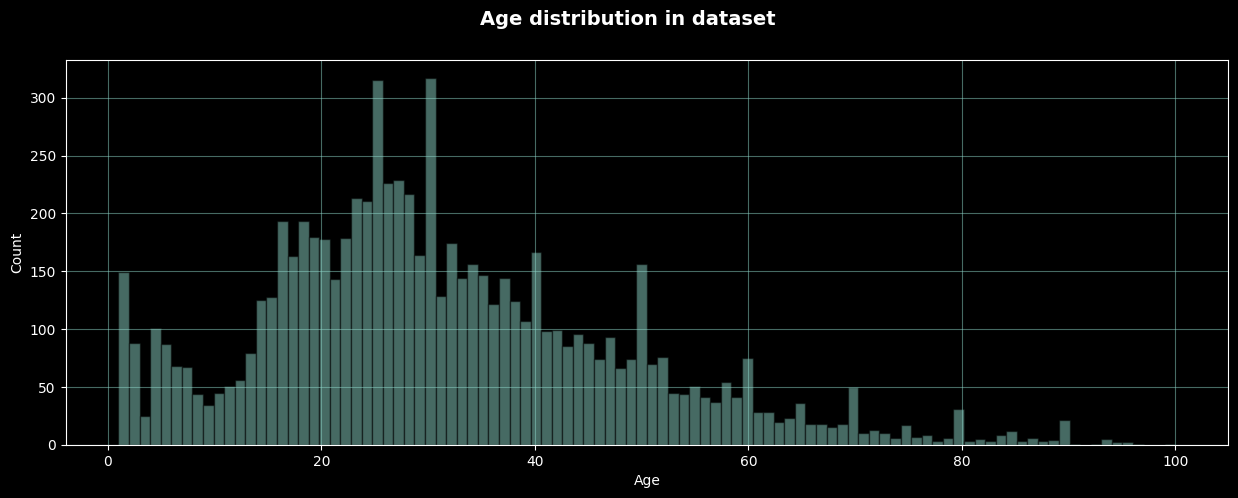

In [4]:
fig = plt.figure(figsize = (15, 5))
ax = fig.add_subplot()
fig.subplots_adjust()
fig.suptitle('Age distribution in dataset', fontsize=14, fontweight='bold')
ax.set_xlabel('Age')
ax.set_ylabel('Count')
plt.grid(color=(0.55, 0.83, 0.78), alpha=0.5)
plt.hist(df_full['real_age'],color=(0.55, 0.83, 0.78), alpha=0.5, edgecolor = 'black', bins = 100)
plt.show();

In [5]:
df_full.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


In [6]:
datagen = ImageDataGenerator(rescale=1./255)

gen_flow = datagen.flow_from_dataframe(
        dataframe=df_full,
        x_col='file_path',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=1337)

features, target = next(gen_flow)

Found 7591 validated image filenames.


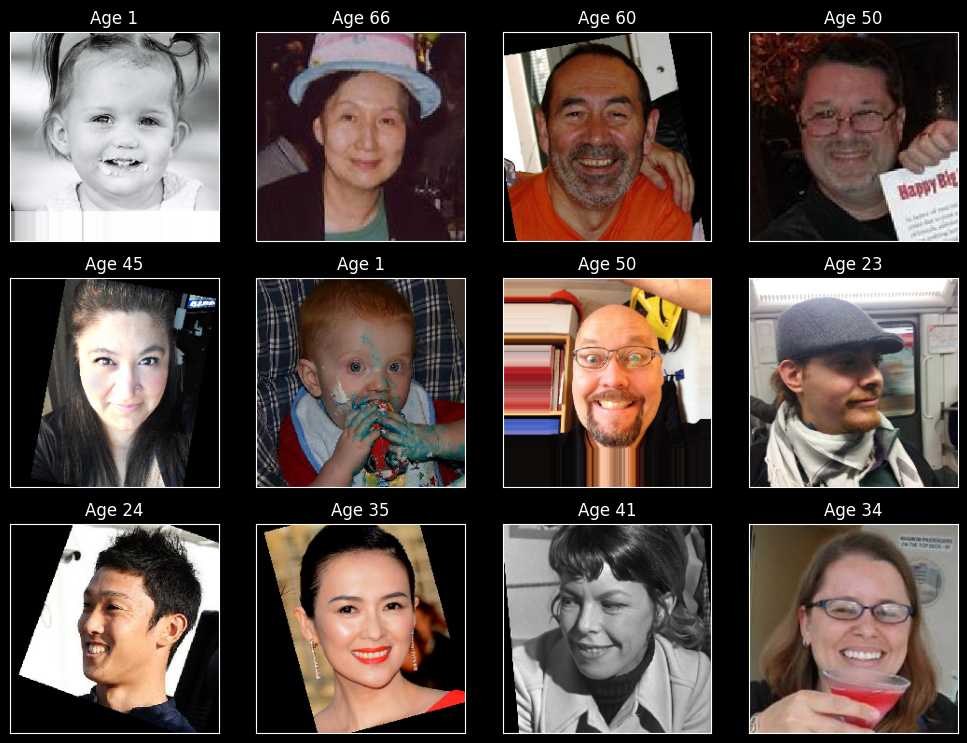

In [7]:
fig = plt.figure(figsize=(10,10))
for i in range(12):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.title('Age ' + str(target[i]))
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

### Conclusion from data analysis

- a dataset of 7591 face photos with tagged age is loaded. This amount is enough to build a model
- most of the faces in the dataset belong to people around 30 years old (29 by median and about 31 by average)
- minimum and maximum ages are 1 year and 100 years
- faces in the photos are centered and brought to similar sizes, eyes are in the centers horizontally and in the upper third vertically
- cropped and rotated edges show that the photos were pre-processed
- horizontal reflection is suitable from the augmentation since the faces are symmetrical horizontally and the reflected photo will remain natural
- the following are not suitable: vertical reflection since this will flip the face and make the photo unnatural; shifts and rotations since they will greatly knock the photos out of the format to which they were adjusted and will add even more black areas to those photos where they already exist

# Model training

### Creating a training flow

In [8]:
datagen = ImageDataGenerator(
    validation_split=0.25,
    rescale=1./255,
    horizontal_flip=True
    )

In [9]:
train_gen_flow = datagen.flow_from_dataframe(
    dataframe=df_full,
    x_col='file_path',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=16,
    class_mode='raw',
    subset='training',
    seed=1337)

Found 5694 validated image filenames.


### Creating a test flow

In [22]:
test_datagen_flow = datagen.flow_from_dataframe(
    dataframe=df_full,
    x_col='file_path',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=16,
    class_mode='raw',
    subset='validation',
    seed=1337)

Found 1897 validated image filenames.


### Geting image shape

In [23]:
image = Image.open(df_full['file_path'][0])

if len(np.array(image).shape) == 3:
    channels = np.array(image).shape[2]
else:
    channels = 1

input_shape = (image.size[0], image.size[1], channels)

print(input_shape)

(114, 114, 3)


In [24]:
backbone = ResNet50(
    input_shape=input_shape,
    weights='imagenet',
    include_top=False) 
model = Sequential()
model.add(backbone)
model.add(GlobalAveragePooling2D())
model.add(Dense(1, activation='relu'))

optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae']) 
model.fit(
    train_gen_flow,
    validation_data=test_datagen_flow,
    batch_size=16,
    epochs=10,
    steps_per_epoch=len(train_gen_flow),
    validation_steps=len(test_datagen_flow),
    shuffle=True,
    verbose=2)

Epoch 1/10
356/356 - 171s - loss: 229.3934 - mae: 10.8441 - val_loss: 616.6444 - val_mae: 19.7893 - 171s/epoch - 481ms/step
Epoch 2/10
356/356 - 82s - loss: 90.4531 - mae: 7.2506 - val_loss: 138.3178 - val_mae: 9.3257 - 82s/epoch - 230ms/step
Epoch 3/10
356/356 - 86s - loss: 64.7000 - mae: 6.1091 - val_loss: 85.6332 - val_mae: 6.8833 - 86s/epoch - 242ms/step
Epoch 4/10
356/356 - 86s - loss: 51.1973 - mae: 5.4531 - val_loss: 74.3945 - val_mae: 6.3964 - 86s/epoch - 241ms/step
Epoch 5/10
356/356 - 86s - loss: 36.5011 - mae: 4.6250 - val_loss: 104.5848 - val_mae: 7.9641 - 86s/epoch - 242ms/step
Epoch 6/10
356/356 - 88s - loss: 31.2079 - mae: 4.2663 - val_loss: 88.4751 - val_mae: 6.8481 - 88s/epoch - 247ms/step
Epoch 7/10
356/356 - 86s - loss: 27.0945 - mae: 3.9768 - val_loss: 73.9300 - val_mae: 6.5667 - 86s/epoch - 243ms/step
Epoch 8/10
356/356 - 86s - loss: 22.5216 - mae: 3.6079 - val_loss: 78.3364 - val_mae: 6.5127 - 86s/epoch - 243ms/step
Epoch 9/10
356/356 - 87s - loss: 19.3580 - mae: 

In [25]:
test_loss, test_mae = model.evaluate(test_datagen_flow, steps=len(test_datagen_flow), verbose=2)
print(f"Test Loss: {test_loss}")
print(f"Test MAE: {test_mae}")

119/119 - 9s - loss: 86.3710 - mae: 7.2288 - 9s/epoch - 73ms/step
Test Loss: 86.37095642089844
Test MAE: 7.228752136230469


### Saving model

In [26]:
model.save('saved_model/my_model')

INFO:tensorflow:Assets written to: saved_model/my_model\assets


INFO:tensorflow:Assets written to: saved_model/my_model\assets


code for using this model in the future

In [ ]:
# from tensorflow.keras.models import load_model
# model = load_model('saved_model/my_model')

## Analysis of a trained model

To train the model, augmentation with horizontal reflection was performed, brightness was reduced to the range [0,1]
The backbone of the pre-trained ResNet50 model was taken as a basis, freezing was not performed since there are enough photos in the sample.
batch size is 16 photos, Adam optimizer with a step of 0.0001, loss function MSE.

Based on the fact that the metrics on the training sample are better than on the test one (for example, on the 10th epoch, MAE is 3.2091 on the training one and 7.2288 on the test one), we can conclude that the model has been overtrained, but this is normal for such models

The model has reached the required MAE value (less than 8 in 10 epochs). but sufficient quality could have been achieved in fewer epochs, thereby making the model faster.

- The final MAE metric was 7.2288